## Predição de Status de entrega OLIST



# Preparação 

Preparando os pacotes que irão ser utilizados e carregando os dados do banco de dados.

In [7]:
#Importação dos Pacotes
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo
#import pymssql as sql #conexão SQL
import psycopg2 as sql


#Novos pacotes para testar tipos de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.options.display.float_format = '{:.2f}'.format

In [76]:
#Importação dos arquivos direto do banco de dados MSSQL

# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect(database = "olist", host = "localhost", user = "etlolist", password = "abc123", port = "5433")

# Chama a consulta ao banco de dados passando os parametros da conexão criada
df_original = pd.read_sql_query('select * from dw_entrega', conexao)

# Fecha conexão com banco de dados
conexao.close()

## Análise

In [77]:
#Tamanho do conjunto de dados. 
df_original.shape

(115412, 23)

In [78]:
#Visão geral do conjunto de dados
df_original.head(5)

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_state,customer_city,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,seller_zip_code_prefix,seller_city,seller_state,tempo_entrega,diferenca_entrega
0,ADA48B7CE9FEE2A62CD265BD45A9C97B,DELIVERED,2017-05-28 23:22:32,2017-05-28 23:35:16,2017-05-29 10:34:43,2017-06-28 16:09:45,2017-06-23,73840,GO,CAMPOS BELOS,2017-06-01 23:35:16,140.0,30.0,1,CREDIT_CARD,4,170,MOVEIS_SALA,37580,MONTE SIAO,MG,30.0,5.0
1,B012C1697921F54E80780E034A93C871,DELIVERED,2018-01-21 11:13:57,2018-01-22 13:47:19,2018-01-23 21:13:24,2018-02-03 13:12:35,2018-02-14,4061,SP,SAO PAULO,2018-01-26 13:47:19,140.0,24.0,1,CREDIT_CARD,10,164,MOVEIS_SALA,37580,MONTE SIAO,MG,11.0,-10.0
2,B45218774C4D91E22FFD4165C0CBCC38,DELIVERED,2018-02-17 18:05:16,2018-02-17 18:15:30,2018-02-19 10:04:40,2018-03-09 21:09:45,2018-03-14,79803,MS,DOURADOS,2018-02-22 17:15:30,140.0,45.0,1,CREDIT_CARD,1,185,MOVEIS_SALA,37580,MONTE SIAO,MG,20.0,-4.0
3,DBBA7FF437DCECD5E70B6EA4BB3AB37B,DELIVERED,2018-01-29 22:44:15,2018-01-30 22:35:48,2018-01-31 22:48:48,2018-02-07 19:16:40,2018-02-21,7160,SP,GUARULHOS,2018-02-05 22:35:48,140.0,24.0,1,CREDIT_CARD,6,164,MOVEIS_SALA,37580,MONTE SIAO,MG,7.0,-13.0
4,F7364D7A775833B673741FAD4D394512,DELIVERED,2017-10-22 19:29:49,2017-10-22 19:49:19,2017-10-23 21:13:16,2017-10-31 19:43:56,2017-11-14,18120,SP,MAIRINQUE,2017-10-26 19:49:19,140.0,32.0,1,CREDIT_CARD,3,172,MOVEIS_SALA,37580,MONTE SIAO,MG,8.0,-13.0


In [79]:
# Analisando os dados missing podemos constatar o seguinte:
# Sem dados nulos

df_original.isnull().sum()

order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_zip_code_prefix         0
customer_state                   0
customer_city                    0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
product_category_name            0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
tempo_entrega                    0
diferenca_entrega                0
dtype: int64

In [80]:
#Informações básicas sobre tipos de variáveis
df_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115412 entries, 0 to 115411
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115412 non-null  object        
 1   order_status                   115412 non-null  object        
 2   order_purchase_timestamp       115412 non-null  datetime64[ns]
 3   order_approved_at              115412 non-null  datetime64[ns]
 4   order_delivered_carrier_date   115412 non-null  datetime64[ns]
 5   order_delivered_customer_date  115412 non-null  datetime64[ns]
 6   order_estimated_delivery_date  115412 non-null  datetime64[ns]
 7   customer_zip_code_prefix       115412 non-null  int64         
 8   customer_state                 115412 non-null  object        
 9   customer_city                  115412 non-null  object        
 10  shipping_limit_date            115412 non-null  datetime64[ns]
 11  

In [81]:
# Avaliar o período dos dados coletados
inicio = pd.to_datetime(df_original['order_purchase_timestamp']).dt.date.min()
fim = pd.to_datetime(df_original['order_purchase_timestamp']).dt.date.max()
print('Período dos dados - De:', inicio, 'Até:',fim)

Período dos dados - De: 2016-09-05 Até: 2018-08-29


In [82]:
# Total de valores únicos de cada variável
# A variável TIPO_FINANCIAMENTO possui valor unico, então será retirada do nosso DataFrame

valores_unicos = []
for i in df_original.columns[0:20].tolist():
    print(i, ':', len(df_original[i].astype(str).value_counts()))
    valores_unicos.append(len(df_original[i].astype(str).value_counts()))

order_id : 96275
order_status : 2
order_purchase_timestamp : 95758
order_approved_at : 88122
order_delivered_carrier_date : 79662
order_delivered_customer_date : 95022
order_estimated_delivery_date : 447
customer_zip_code_prefix : 14882
customer_state : 27
customer_city : 4084
shipping_limit_date : 91169
price : 1051
freight_value : 235
payment_sequential : 26
payment_type : 4
payment_installments : 24
payment_value : 1622
product_category_name : 74
seller_zip_code_prefix : 2194
seller_city : 601


In [83]:
# Visualizando algumas medidas estatisticas
df_original.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,tempo_entrega,diferenca_entrega
count,115412,115412,115412,115412,115412,115412.000000,115412,115412.000000,115412.000000,115412.000000,115412.000000,115412.000000,115412.000000,115412.000000,115412.000000
mean,2017-12-31 10:03:10.050548992,2018-01-09 12:50:24.083388416,2018-10-10 04:24:11.543808256,2018-11-28 00:24:19.486829824,2018-01-24 05:49:01.960974336,35052.131797,2018-01-07 00:57:40.218348032,120.109347,19.972143,1.091585,2.938559,171.726016,24451.352390,321.994871,307.999575
min,2016-09-05 00:15:34,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-25 00:00:00,1003.000000,2016-09-19 00:15:34,1.000000,0.000000,1.000000,0.000000,0.000000,1001.000000,-66809.000000,-146.000000
25%,2017-09-12 16:29:02.750000128,2017-09-13 03:24:53.750000128,2017-09-15 19:26:32.249999872,2017-09-25 17:57:50,2017-10-03 00:00:00,11090.000000,2017-09-19 17:09:20.249999872,40.000000,13.000000,1.000000,1.000000,61.000000,6429.000000,6.000000,-16.000000
50%,2018-01-19 03:30:43,2018-01-19 14:59:24,2018-01-24 01:14:44,2018-02-02 10:16:35,2018-02-15 00:00:00,24240.000000,2018-01-25 19:37:09.500000,75.000000,16.000000,1.000000,2.000000,108.000000,13608.500000,9.000000,-12.000000
75%,2018-05-04 13:56:23,2018-05-04 21:50:16.500000,2018-05-08 14:48:30,2018-05-16 01:21:41.249999872,2018-05-25 00:00:00,58755.000000,2018-05-10 12:13:55,133.000000,21.000000,1.000000,4.000000,189.000000,27987.750000,15.000000,-6.000000
max,2018-08-29 15:00:37,2200-01-01 00:00:00,2200-01-01 00:00:00,2200-01-01 00:00:00,2018-10-25 00:00:00,99980.000000,2020-04-09 22:35:08,6735.000000,410.000000,26.000000,24.000000,13664.000000,99730.000000,66925.000000,66907.000000
std,NaN,NaN,NaN,NaN,NaN,29871.056992,NaN,182.560210,15.720055,0.688572,2.774098,265.339164,27588.499657,4658.706466,4595.578802


In [84]:
print('Maior Valor de compra:', df_original['price'].max())
print('Menor Valor de compra:', df_original['price'].min())

Maior Valor de compra: 6735.0
Menor Valor de compra: 1.0


In [85]:
# A variavel alvo precisará ser balanceada na etapa de pré-processamento
df_original.groupby(['order_status']).size()

order_status
CANCELED        553
DELIVERED    114859
dtype: int64

# Tratamento

In [86]:
# Criando faixa salarial para utilizarmos no modelo preditivo
bins = [-100, 100, 500, 1000, 2000, 3000, 4000, 5000, 9000000000]
labels = ['Até 100 reais', '101 até 500 reais', '501 até 1000 reais', '1001 até 2000 reais', '2001 até 3000 reais', 
          '3001 até 4000 reais', 'De 4001 até 5000 reais','Mais de 5000 reais']
df_original['faixa_preco'] = pd.cut(df_original['price'], bins=bins, labels=labels)
pd.value_counts(df_original.faixa_preco)

faixa_preco
Até 100 reais             74493
101 até 500 reais         37664
501 até 1000 reais         2395
1001 até 2000 reais         735
2001 até 3000 reais          98
3001 até 4000 reais          19
De 4001 até 5000 reais        6
Mais de 5000 reais            2
Name: count, dtype: int64

In [87]:
df_original.head(5)

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_state,customer_city,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,seller_zip_code_prefix,seller_city,seller_state,tempo_entrega,diferenca_entrega,faixa_preco
0,ADA48B7CE9FEE2A62CD265BD45A9C97B,DELIVERED,2017-05-28 23:22:32,2017-05-28 23:35:16,2017-05-29 10:34:43,2017-06-28 16:09:45,2017-06-23,73840,GO,CAMPOS BELOS,2017-06-01 23:35:16,140.0,30.0,1,CREDIT_CARD,4,170,MOVEIS_SALA,37580,MONTE SIAO,MG,30.0,5.0,101 até 500 reais
1,B012C1697921F54E80780E034A93C871,DELIVERED,2018-01-21 11:13:57,2018-01-22 13:47:19,2018-01-23 21:13:24,2018-02-03 13:12:35,2018-02-14,4061,SP,SAO PAULO,2018-01-26 13:47:19,140.0,24.0,1,CREDIT_CARD,10,164,MOVEIS_SALA,37580,MONTE SIAO,MG,11.0,-10.0,101 até 500 reais
2,B45218774C4D91E22FFD4165C0CBCC38,DELIVERED,2018-02-17 18:05:16,2018-02-17 18:15:30,2018-02-19 10:04:40,2018-03-09 21:09:45,2018-03-14,79803,MS,DOURADOS,2018-02-22 17:15:30,140.0,45.0,1,CREDIT_CARD,1,185,MOVEIS_SALA,37580,MONTE SIAO,MG,20.0,-4.0,101 até 500 reais
3,DBBA7FF437DCECD5E70B6EA4BB3AB37B,DELIVERED,2018-01-29 22:44:15,2018-01-30 22:35:48,2018-01-31 22:48:48,2018-02-07 19:16:40,2018-02-21,7160,SP,GUARULHOS,2018-02-05 22:35:48,140.0,24.0,1,CREDIT_CARD,6,164,MOVEIS_SALA,37580,MONTE SIAO,MG,7.0,-13.0,101 até 500 reais
4,F7364D7A775833B673741FAD4D394512,DELIVERED,2017-10-22 19:29:49,2017-10-22 19:49:19,2017-10-23 21:13:16,2017-10-31 19:43:56,2017-11-14,18120,SP,MAIRINQUE,2017-10-26 19:49:19,140.0,32.0,1,CREDIT_CARD,3,172,MOVEIS_SALA,37580,MONTE SIAO,MG,8.0,-13.0,101 até 500 reais


In [111]:

colunas = ['order_status',  
           'customer_state', 'customer_city',
           'freight_value', 'payment_type','payment_value',
           'product_category_name', 'seller_city',
           'seller_state','tempo_entrega', 'diferenca_entrega', 'faixa_preco']

df_dados = pd.DataFrame(df_original, columns=colunas)

In [112]:
df_dados.head()

,order_status,customer_state,customer_city,freight_value,payment_type,payment_value,product_category_name,seller_city,seller_state,tempo_entrega,diferenca_entrega,faixa_preco
0,DELIVERED,GO,CAMPOS BELOS,30.0,CREDIT_CARD,170,MOVEIS_SALA,MONTE SIAO,MG,30.0,5.0,101 até 500 reais
1,DELIVERED,SP,SAO PAULO,24.0,CREDIT_CARD,164,MOVEIS_SALA,MONTE SIAO,MG,11.0,-10.0,101 até 500 reais
2,DELIVERED,MS,DOURADOS,45.0,CREDIT_CARD,185,MOVEIS_SALA,MONTE SIAO,MG,20.0,-4.0,101 até 500 reais
3,DELIVERED,SP,GUARULHOS,24.0,CREDIT_CARD,164,MOVEIS_SALA,MONTE SIAO,MG,7.0,-13.0,101 até 500 reais
4,DELIVERED,SP,MAIRINQUE,32.0,CREDIT_CARD,172,MOVEIS_SALA,MONTE SIAO,MG,8.0,-13.0,101 até 500 reais


In [113]:
df_dados.shape

(115412, 12)

In [114]:
df_dados.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115412 entries, 0 to 115411
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   order_status           115412 non-null  object  
 1   customer_state         115412 non-null  object  
 2   customer_city          115412 non-null  object  
 3   freight_value          115412 non-null  float64 
 4   payment_type           115412 non-null  object  
 5   payment_value          115412 non-null  int64   
 6   product_category_name  115412 non-null  object  
 7   seller_city            115412 non-null  object  
 8   seller_state           115412 non-null  object  
 9   tempo_entrega          115412 non-null  float64 
 10  diferenca_entrega      115412 non-null  float64 
 11  faixa_preco            115412 non-null  category
dtypes: category(1), float64(3), int64(1), object(7)
memory usage: 9.8+ MB


In [115]:
df_dados.isnull().sum()

order_status             0
customer_state           0
customer_city            0
freight_value            0
payment_type             0
payment_value            0
product_category_name    0
seller_city              0
seller_state             0
tempo_entrega            0
diferenca_entrega        0
faixa_preco              0
dtype: int64

# Análise exploratória 

Nesta analise temos 2 objetivos: a variável alvo (INADIMPLENTE_COBRANCA), avaliar as variáveis categóricas para conhecimento dos dados e descartar variáveis que não fazem sentido.

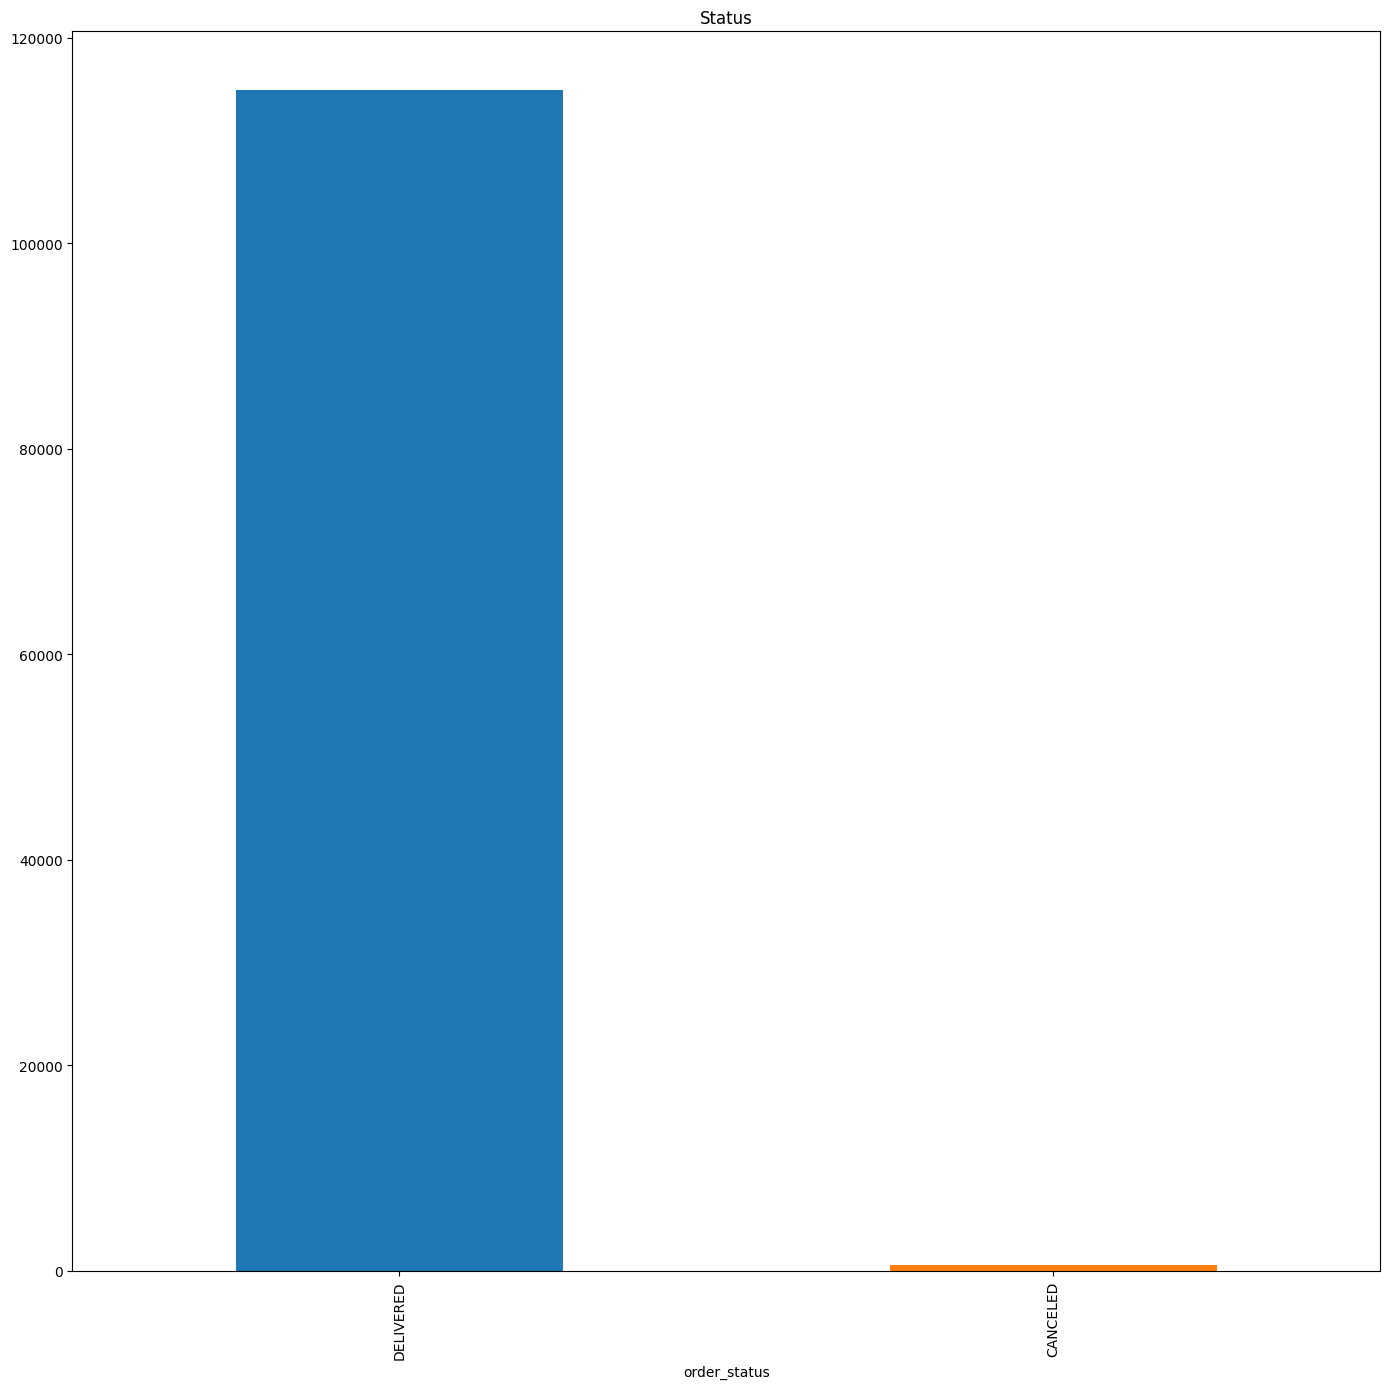

In [116]:
#Analisando como a variavel alvo está distribuida.
df_dados.order_status.value_counts().plot(kind='bar', title='Status',color = ['#1F77B4', '#FF7F0E']);


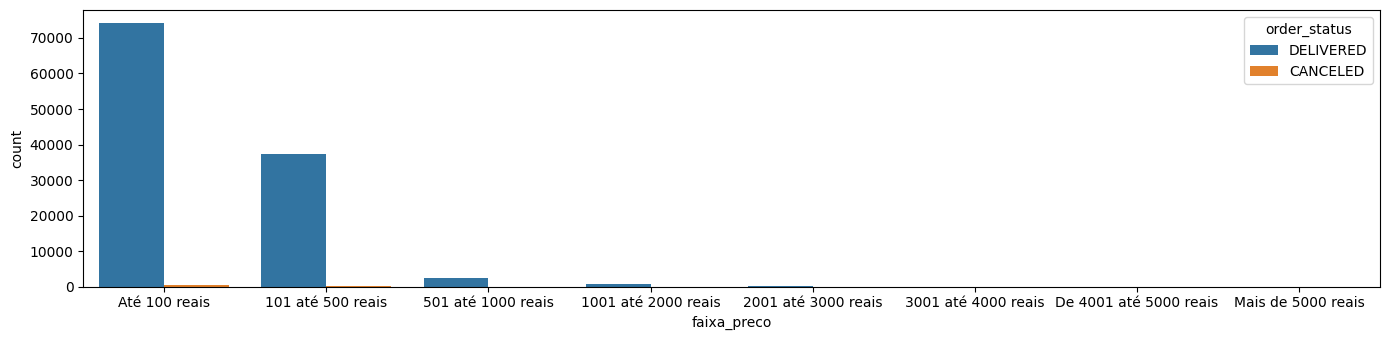

In [117]:
plt.rcParams["figure.figsize"] = [14.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.countplot(data = df_dados, x = "faixa_preco", hue = "order_status")
plt.show()

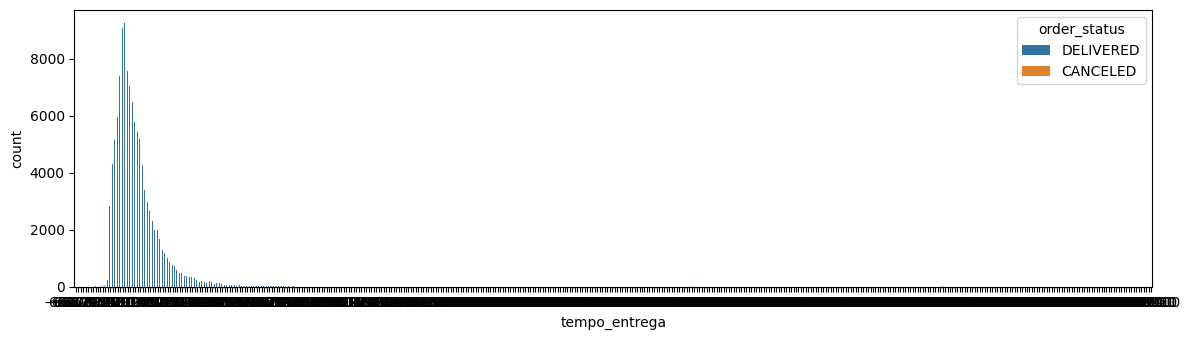

In [118]:
plt.rcParams["figure.figsize"] = [12.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.countplot(data = df_dados, x = "tempo_entrega", hue = "order_status")
plt.show()

# Analise de Variaveis numericas

In [119]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115412 entries, 0 to 115411
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   order_status           115412 non-null  object  
 1   customer_state         115412 non-null  object  
 2   customer_city          115412 non-null  object  
 3   freight_value          115412 non-null  float64 
 4   payment_type           115412 non-null  object  
 5   payment_value          115412 non-null  int64   
 6   product_category_name  115412 non-null  object  
 7   seller_city            115412 non-null  object  
 8   seller_state           115412 non-null  object  
 9   tempo_entrega          115412 non-null  float64 
 10  diferenca_entrega      115412 non-null  float64 
 11  faixa_preco            115412 non-null  category
dtypes: category(1), float64(3), int64(1), object(7)
memory usage: 9.8+ MB


In [120]:
#carregar variaveis para plot
variaveis_numericas = []
for i in df_dados.columns[0:12].tolist():
        if df_dados.dtypes[i] == 'int64' or df_dados.dtypes[i] == 'float64':                        
            variaveis_numericas.append(i)    

In [121]:
#Visualizando as variáveis numéricas
variaveis_numericas

['freight_value', 'payment_value', 'tempo_entrega', 'diferenca_entrega']

In [122]:
#Quantidade de variaveis
len(variaveis_numericas)

4

In [124]:
# carregar variaveis categoricas para OneHotEncoding, ou seja transformar os campos categoricos em valores inteiros
# Colocamos o SLICE até 16 porque NÃO precisamos fazer OneHotEncoding para variavel TARGET
variaveis_categoricas = []
for i in df_dados.columns[0:12].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i)    

In [125]:
# Visualizando as variaveis categoricas
variaveis_categoricas

['order_status',
 'customer_state',
 'customer_city',
 'payment_type',
 'product_category_name',
 'seller_city',
 'seller_state',
 'faixa_preco']

In [126]:
# Cria o encoder e aplica OneHotEncoder
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])

In [127]:
df_dados.head()

,order_status,customer_state,customer_city,freight_value,payment_type,payment_value,product_category_name,seller_city,seller_state,tempo_entrega,diferenca_entrega,faixa_preco
0,1,8,728,30.0,1,170,57,342,7,30.0,5.0,1
1,1,25,3562,24.0,1,164,57,342,7,11.0,-10.0,1
2,1,11,1216,45.0,1,185,57,342,7,20.0,-4.0,1
3,1,25,1518,24.0,1,164,57,342,7,7.0,-13.0,1
4,1,25,2152,32.0,1,172,57,342,7,8.0,-13.0,1


In [128]:
# Visualizando os tipos das variaveis
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115412 entries, 0 to 115411
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_status           115412 non-null  int64  
 1   customer_state         115412 non-null  int64  
 2   customer_city          115412 non-null  int64  
 3   freight_value          115412 non-null  float64
 4   payment_type           115412 non-null  int64  
 5   payment_value          115412 non-null  int64  
 6   product_category_name  115412 non-null  int64  
 7   seller_city            115412 non-null  int64  
 8   seller_state           115412 non-null  int64  
 9   tempo_entrega          115412 non-null  float64
 10  diferenca_entrega      115412 non-null  float64
 11  faixa_preco            115412 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 10.6 MB


# Balanceamento

In [129]:
# Visualiznado a quantidade da variavel target para balanceamento
variavel_target = df_dados.order_status.value_counts()
variavel_target

order_status
1    114859
0       553
Name: count, dtype: int64

In [130]:
#Separar variaveis preditoras e target
PREDITORAS = df_dados.iloc[:, 1:11]  
TARGET = df_dados.iloc[:, 0] 

In [131]:
# Visualizando as variaveis preditoras
PREDITORAS.head()

,customer_state,customer_city,freight_value,payment_type,payment_value,product_category_name,seller_city,seller_state,tempo_entrega,diferenca_entrega
0,8,728,30.0,1,170,57,342,7,30.0,5.0
1,25,3562,24.0,1,164,57,342,7,11.0,-10.0
2,11,1216,45.0,1,185,57,342,7,20.0,-4.0
3,25,1518,24.0,1,164,57,342,7,7.0,-13.0
4,25,2152,32.0,1,172,57,342,7,8.0,-13.0


In [132]:
# Visualizando a variavel target
TARGET.head()

0    1
1    1
2    1
3    1
4    1
Name: order_status, dtype: int64

In [133]:
# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

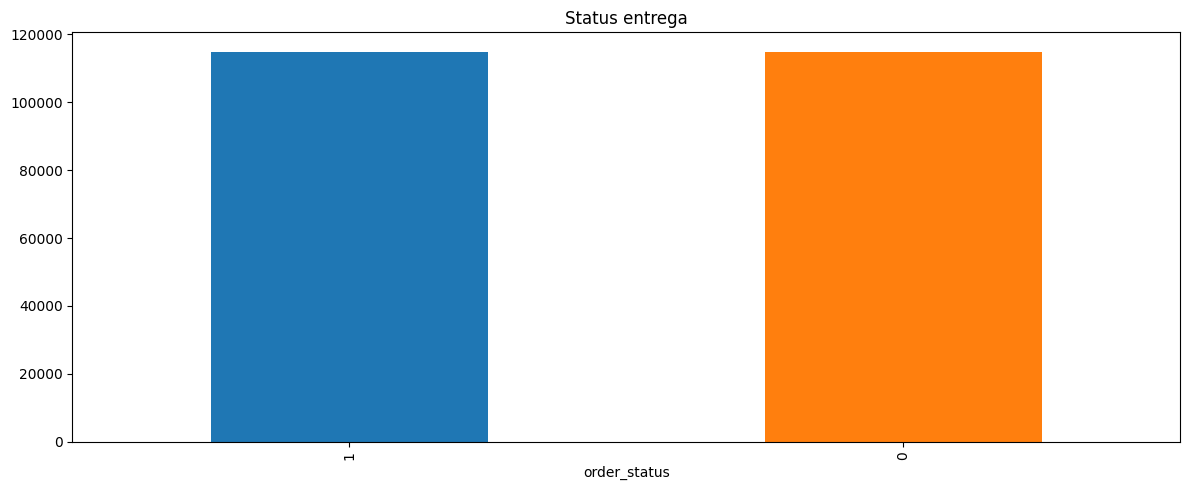

In [135]:
# Visualizando o balanceamento da variável TARGET
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Status entrega',color = ['#1F77B4', '#FF7F0E']);

In [136]:
# Quantidade de registros antes do balanceamento
PREDITORAS.shape

(115412, 10)

In [137]:
# Quantidade de registros antes do balanceamento
TARGET.shape

(115412,)

In [138]:
# Quantidade de registros após do balanceamento
PREDITORAS_RES.shape

(229718, 10)

In [139]:
# Quantidade de registros após do balanceamento
TARGET_RES.shape

(229718,)

# Separação e normalização dos dados / Criação e treino do modelo / Avaliação de métricas

In [140]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)

In [141]:
# Normalizando as Variáveis - Pré Processamento dos Dados
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

In [142]:
# visualizando a dimensão dos dados de treino
X_treino_normalizados.shape

(160802, 10)

In [143]:
# visualizando os dados de treino normalizados
X_treino_normalizados

array([[0.96153846, 0.87236649, 0.04634146, ..., 0.66666667, 0.49953629,
        0.00207299],
       [0.96153846, 0.50930916, 0.03658537, ..., 0.66666667, 0.49956621,
        0.00207299],
       [0.96153846, 0.79152376, 0.03658537, ..., 0.9047619 , 0.49948393,
        0.00193876],
       ...,
       [0.96153846, 0.87236649, 0.04146341, ..., 1.        , 0.99778615,
        0.99557067],
       [0.84615385, 0.2922587 , 0.0430857 , ..., 0.80952381, 0.99773531,
        0.99536988],
       [0.69230769, 0.7655561 , 0.04501084, ..., 0.80952381, 0.99726277,
        0.99456499]])

In [144]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators  = 300)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

In [145]:
# Criando o classificador com SVC
clf2 = SVC()

# Construção do modelo
clf2 = clf2.fit(X_treino_normalizados, Y_treino)

In [146]:
# Criando o classificador com Logistic Regression
clf3 = LogisticRegression()

# Construção do modelo
clf3 = clf3.fit(X_treino_normalizados, Y_treino)

In [147]:
# Criando o classificador com Decision Tree 
clf4 = DecisionTreeClassifier()

# Construção do modelo
clf4 = clf4.fit(X_treino_normalizados, Y_treino)

In [148]:
# Criando o classificador com KNeighbors
clf5 = KNeighborsClassifier()

# Construção do modelo
clf5 = clf5.fit(X_treino_normalizados, Y_treino)

In [149]:
# Criando o classificador com MLP
clf6 = MLPClassifier()

# Construção do modelo
clf6 = clf6.fit(X_treino_normalizados, Y_treino)

In [150]:
# Criando o classificador com Gradient Boosting
clf7 = GradientBoostingClassifier()

# Construção do modelo
clf7 = clf7.fit(X_treino_normalizados, Y_treino)

In [74]:
# # Criando o classificador com XGB
# clf8 = XGBClassifier()

# # Construção do modelo
# clf8 = clf8.fit(X_treino_normalizados, Y_treino)

In [151]:
# Criando o classificador com LGBM
clf9 = LGBMClassifier()

# Construção do modelo
clf9 = clf9.fit(X_treino_normalizados, Y_treino)

[LightGBM] [Info] Number of positive: 80543, number of negative: 80259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 160802, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500883 -> initscore=0.003532
[LightGBM] [Info] Start training from score 0.003532


In [152]:
# Verificando a acuracia do modelo com dados de teste Random Forest
scores = clf.score(X_teste_normalizados,Y_teste)
scores

0.9999564687445586

In [153]:
# Verificando a acuracia do modelo com dados de teste SVC
scores = clf2.score(X_teste_normalizados,Y_teste)
scores

0.9928753845260897

In [154]:
# Verificando a acuracia do modelo com dados de teste Logistic Regression
scores = clf3.score(X_teste_normalizados,Y_teste)
scores

0.9928753845260897

In [155]:
# Verificando a acuracia do modelo com dados de teste Decision Tree 
scores = clf4.score(X_teste_normalizados,Y_teste)
scores

0.9997243020488711

In [156]:
# Verificando a acuracia do modelo com dados de teste KNeighbors
scores = clf5.score(X_teste_normalizados,Y_teste)
scores

0.999318010331418

In [157]:
# Verificando a acuracia do modelo com dados de teste MLP
scores = clf6.score(X_teste_normalizados,Y_teste)
scores

0.998360322711707

In [158]:
# Verificando a acuracia do modelo com dados de teste Gradient Boosting
scores = clf7.score(X_teste_normalizados,Y_teste)
scores

0.9989262290324453

In [159]:
# # Verificando a acuracia do modelo com dados de teste XGB
# scores = clf8.score(X_teste_normalizados,Y_teste)
# scores

In [160]:
# Verificando a acuracia do modelo com dados de teste LGBM
scores = clf9.score(X_teste_normalizados,Y_teste)
scores

0.9999129374891171

Identificado que a Random Forest foi o melhor modelo para ser utilizado devido sua melhor acuracia.

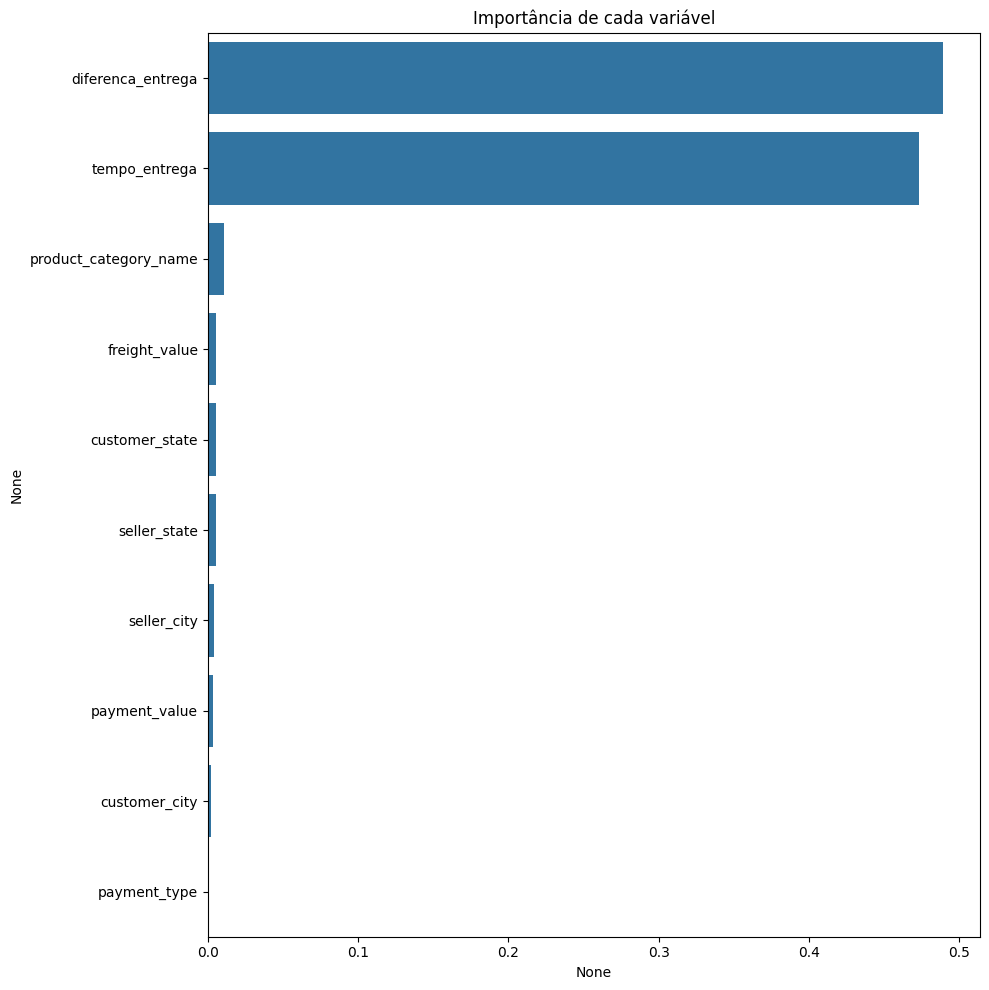

In [161]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [162]:
importances.sort_values(ascending = False)

diferenca_entrega        0.489325
tempo_entrega            0.473297
product_category_name    0.010762
freight_value            0.005539
customer_state           0.005399
seller_state             0.005298
seller_city              0.004116
payment_value            0.003413
customer_city            0.002363
payment_type             0.000488
dtype: float64

In [163]:
# Salvando o modelo criado e treinado
joblib.dump(clf, 'modelo_status_treinado.pk')

['modelo_status_treinado.pk']

# Preparação para produção

In [167]:
# Carregando o modelo treinado
clf = joblib.load('modelo_status_treinado.pk')

In [168]:
#Importação do arquivo de dados

# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect(database = "olist", host = "localhost", user = "etlolist", password = "abc123", port = "5433")

# Chama a consulta ao banco de dados passando os parametros da conexão criada
df_original = pd.read_sql_query('select * from dw_entrega', conexao)

# Fecha conexão com banco de dados
conexao.close()

In [170]:
# Excluindo dados missing
df_original.dropna(inplace=True)


# Criando faixa salarial para utilizarmos no modelo preditivo
bins = [-100, 100, 500, 1000, 2000, 3000, 4000, 5000, 9000000000]
labels = ['Até 100 reais', '101 até 500 reais', '501 até 1000 reais', '1001 até 2000 reais', '2001 até 3000 reais', 
          '3001 até 4000 reais', 'De 4001 até 5000 reais','Mais de 5000 reais']
df_original['faixa_preco'] = pd.cut(df_original['price'], bins=bins, labels=labels)
pd.value_counts(df_original.faixa_preco)

colunas = ['order_status',  
           'customer_state', 'customer_city',
           'freight_value', 'payment_type','payment_value',
           'product_category_name', 'seller_city',
           'seller_state','tempo_entrega', 'diferenca_entrega', 'faixa_preco']

df_dados = pd.DataFrame(df_original, columns=colunas)

# carregar variaveis categoricas para OneHotEncoding

variaveis_categoricas = []
for i in df_dados.columns[0:12].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i)        
            

lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])

# Separar variaveis preditoras
PREDITORAS = df_dados.iloc[:, 0:10]          
    

# Fazendo a normalização dos dados    
Normalizador = MinMaxScaler()
dados_normalizados = Normalizador.fit_transform(PREDITORAS)

previsoes = clf.predict(dados_normalizados)
probabilidades = clf.predict_proba(dados_normalizados)
df_original['PREVISOES'] = previsoes
df_original['PROBABILIDADES'] = probabilidades[:, 1]
df_original.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_state,customer_city,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,seller_zip_code_prefix,seller_city,seller_state,tempo_entrega,diferenca_entrega,faixa_preco,PREVISOES,PROBABILIDADES
0,ADA48B7CE9FEE2A62CD265BD45A9C97B,DELIVERED,2017-05-28 23:22:32,2017-05-28 23:35:16,2017-05-29 10:34:43,2017-06-28 16:09:45,2017-06-23,73840,GO,CAMPOS BELOS,2017-06-01 23:35:16,140.0,30.0,1,CREDIT_CARD,4,170,MOVEIS_SALA,37580,MONTE SIAO,MG,30.0,5.0,101 até 500 reais,0,0.490000
1,B012C1697921F54E80780E034A93C871,DELIVERED,2018-01-21 11:13:57,2018-01-22 13:47:19,2018-01-23 21:13:24,2018-02-03 13:12:35,2018-02-14,4061,SP,SAO PAULO,2018-01-26 13:47:19,140.0,24.0,1,CREDIT_CARD,10,164,MOVEIS_SALA,37580,MONTE SIAO,MG,11.0,-10.0,101 até 500 reais,0,0.483333
2,B45218774C4D91E22FFD4165C0CBCC38,DELIVERED,2018-02-17 18:05:16,2018-02-17 18:15:30,2018-02-19 10:04:40,2018-03-09 21:09:45,2018-03-14,79803,MS,DOURADOS,2018-02-22 17:15:30,140.0,45.0,1,CREDIT_CARD,1,185,MOVEIS_SALA,37580,MONTE SIAO,MG,20.0,-4.0,101 até 500 reais,0,0.490000
3,DBBA7FF437DCECD5E70B6EA4BB3AB37B,DELIVERED,2018-01-29 22:44:15,2018-01-30 22:35:48,2018-01-31 22:48:48,2018-02-07 19:16:40,2018-02-21,7160,SP,GUARULHOS,2018-02-05 22:35:48,140.0,24.0,1,CREDIT_CARD,6,164,MOVEIS_SALA,37580,MONTE SIAO,MG,7.0,-13.0,101 até 500 reais,0,0.483333
4,F7364D7A775833B673741FAD4D394512,DELIVERED,2017-10-22 19:29:49,2017-10-22 19:49:19,2017-10-23 21:13:16,2017-10-31 19:43:56,2017-11-14,18120,SP,MAIRINQUE,2017-10-26 19:49:19,140.0,32.0,1,CREDIT_CARD,3,172,MOVEIS_SALA,37580,MONTE SIAO,MG,8.0,-13.0,101 até 500 reais,0,0.483333


In [171]:
df_original.to_excel('df_previsao_entrega_com_probabilidades.xlsx', index = False)